# T-Maze

Experiments with modifications to the t-maze enviroment.

see https://papers.nips.cc/paper/1953-reinforcement-learning-with-long-short-term-memory.pdf

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import sys

import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class TMaze:   
    
    def __init__(self, size=3, step_reward=0.0):
        self.size = size #takes size number of steps to reach decision node
        self.step_reward = step_reward
    
    def __str__(self):
        statement = "Position: {}, Size: {}, Goal: {} ".format(self.position, self.size, self.getGoal(self.goal)) 
        return statement
                
    def getGoal(self, num):
        if num == 1:
            return "E"
        else:
            return "W"
        
    def max_score(self):
        """ returns the maximum possiable score on this enviroment. """
        return 4.0 + self.step_reward * self.size
        
    def step(self, action):
        """
        action - [0,1,2,3]
        directions = ["N","S","E","W"]
        Returns observation and reward
        """
        dx,dy = self.getDis(action)
        
        reward = self.step_reward
        done = False
        
        self.position += dy
        
        #going beyond maze upwards
        if self.position > self.size:
            reward = -0.1
            self.position += -1
        #downwards
        elif self.position < 0:
            reward = -0.1
            self.position += 1
            
        #moving left or right    
        if dx != 0:
            if self.position == self.size:
                if dx == self.goal:
                    reward = 4
                else:
                    reward = -0.1
                self.reset()
                done = True
            else:
                reward = -0.1
        
        return self.getObs(self.position),reward, done    
            
        
    def getObs(self, position):
        if position == 0:
            return self.observations[0]
        elif position == self.size:
            return self.observations[2]
        else:
            return self.observations[1]
    
    def getDis(self, action):
        """
        returns dx and dy, that represent change in position 
        """
        dis = [(0,1), (0,-1), (1,0), (-1,0)]
        return dis[action]
    
    def getAction(self, action):
        """
        for abstraction
        """
        directions = ["N","S","E","W"]
        return directions[action]
    
    def reset(self):
        
        """ Resets and returns initial observation """
        self.position = 0
        goal = random.choice([1,-1])
        self.goal = goal # 1 = 'E' -1 = 'W'        
        #'110' is W ;011 is E, corridor, decision node
        if goal == 1:
            self.observations = [(0,1,1),(1,0,1), (0,1,0)]
        else:
            self.observations = [(1,1,0),(1,0,1), (0,1,0)]
        return self.getObs(0)
    

In [3]:
env = TMaze() #size 3
print(env.reset())

print(env)

print(env.step(1))
print(env.step(2))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(2))

(1, 1, 0)
Position: 0, Size: 3, Goal: W 
((1, 1, 0), -0.1, False)
((1, 1, 0), -0.1, False)
((1, 0, 1), 0.0, False)
((1, 0, 1), 0.0, False)
((0, 1, 0), 0.0, False)
((0, 1, 0), -0.1, False)
((1, 1, 0), -0.1, True)


In [4]:
print(env)

Position: 0, Size: 3, Goal: W 


In [5]:
class RandomAgent():
    
    def __init__(self):
        pass
    
    def act(self, obs,reward, done):
        return random.choice([0,1,2,3])

In [7]:
randAgent = RandomAgent()
env = TMaze()
obs = env.reset()

done = False
reward = 0
totalRewards = []
episodes = 100
totalSteps = []
for i in range(episodes):
    cumReward = 0
    for step in range(1000):
        action = randAgent.act(obs,reward, done)
        obs,reward,done = env.step(action)
        cumReward += reward

        if done:
            break
    totalSteps.append(step)
    totalRewards.append(cumReward)
    #print("CumReward: {}, Steps: {}, Episode: {} ".format(cumReward, step, i)) 


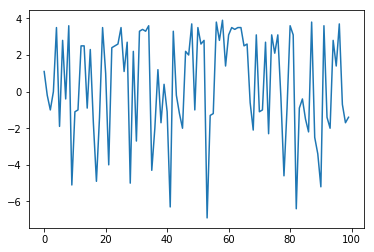

In [9]:
plt.plot(range(episodes), totalRewards)
plt.show()

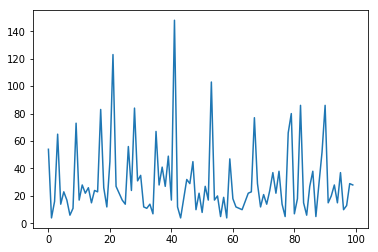

In [10]:
plt.plot(range(episodes), totalSteps)
plt.show()

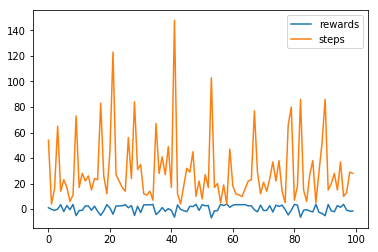

In [11]:
plt.plot(range(episodes), totalRewards, label = "rewards")
plt.plot(range(episodes), totalSteps, label = 'steps')
plt.legend()
plt.show()

# LSTM Agent as per 

https://arxiv.org/pdf/1507.06527.pdf
    

In [12]:
# Our Fast / Slow model
class LSTM_Agent(nn.Module):
    
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001, epsilon=0.1):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)
        
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.epsilon = epsilon
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x):
                
        h = F.relu(self.hidden(x))        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        h = h.unsqueeze(0)
        memory_activations, (self.h_state, self.c_state) = self.lstm(h, (self.h_state, self.c_state))
        q_out = self.q(memory_activations)
        
        return q_out
    
    def act(self, observation, e_greedy=True):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
        
class LSTM_Passthru_Agent(nn.Module):
 
    def __init__(self, input_dims = 3, hidden_dims = 12, memory_dims = 3, actions_dims = 4, learning_rate = 0.001, epsilon=0.1):
        
        super().__init__()
        
        self.memory_dims = memory_dims
        self.actions_dims = actions_dims
        
        self.hidden = nn.Linear(input_dims, hidden_dims)                
        self.lstm = nn.LSTM(hidden_dims, memory_dims)
        
        self.q = nn.Linear(memory_dims + hidden_dims, actions_dims)
                
        self.optimizer = optim.Adam(self.parameters(), learning_rate)
        
        self.epsilon = epsilon
        
        self.reset()
                
    def reset(self):
        # dims are sequence length, batch_size, number of units.
        self.h_state = torch.zeros(1, 1, self.memory_dims)
        self.c_state = torch.zeros(1, 1, self.memory_dims)
        
    def forward(self, x_in):
                            
        h = F.relu(self.hidden(x_in))        
        
        # lstm expects dims 1,1,3 i.e. sequence_length, batch_size, memory units
        memory_in = h.unsqueeze(0)        
        memory_activations, (self.h_state, self.c_state) = self.lstm(memory_in, (self.h_state, self.c_state))
        
        memory_activations = memory_activations.squeeze(0)        
        
        concat = torch.cat([memory_activations, h], dim=1)
        
        q_out = self.q(concat)
        
        return q_out
    
    def act(self, observation, e_greedy=True):
        """ Returns an action based on current policy, and q values """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(range(self.actions_dims))), q
        else:
            # pick optimal            
            return int(np.argmax(q.detach())), q
    

class LSTM_Smart_Agent(LSTM_Agent):
    
    """ This agent can only perform 'valid' actions, which simplifies the learning task to just
        remembering the initial pattern.
    """
    
    def __init__(self, can_go_north_at_end=False, **kwargs):
        super().__init__(**kwargs)
        self.can_go_north_at_end = can_go_north_at_end
    
    
    def act(self, observation, e_greedy=True):
        """ Returns action based on current policy and q values, but
            excludes invalid actions.
        """
        
        observation = torch.FloatTensor(observation).to('cpu')
        observation = observation.unsqueeze(0) # make into dims (1,3)
        q = self(observation).squeeze() # remove the 1 dims.
        
        
        if np.array_equal(np.array(observation[0]), np.array([0,1,0])):
            valid_actions = [0,2,3] if self.can_go_north_at_end else [2,3]
        else:
            valid_actions = [0]
        
        if e_greedy and np.random.rand() < self.epsilon:
            # pick random action
            return int(random.choice(valid_actions)), q
        else:
            # pick optimal            
            q_values_for_valid_actions = [q.detach()[action] for action in valid_actions]
            optimal_valid_action = np.argmax(q_values_for_valid_actions)
            return valid_actions[optimal_valid_action], q

    

In [13]:
# Hyper Parameters

GAMMA = 0.98
EPSILON = 0.10
LEARNING_RATE = 0.0003

PRINT_EVERY = 1000

In [38]:
def eval_agent(agent, env, trials=100, verbose=False, use_egreedy=False):
    """ Evaulates agent by running it greed through a number of trials.
        Returns average reward.
    """
        
    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []

    for i in range(trials):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation, e_greedy=use_egreedy)    

        max_steps = 250

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation, e_greedy=use_egreedy)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            
            if verbose:
                print("step: {} action: {} q: {}, obs: {}, pos: {} ".format(step,next_action, np.array(next_q_values.detach()), next_observation, env.position))
            
            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        totalSteps.append(step)
        totalRewards.append(cumReward)
        
    return np.mean(totalRewards)

def run_test(depth, agent, verbose=False, stepReward=0.0):

    global totalRewards
    global totalSteps
    global scoreHistory
            
    env = TMaze(depth, step_reward=stepReward)

    observation = env.reset()

    done = False
    reward = 0
    totalRewards = []
    totalSteps = []
    scoreHistory = []
    episodes = 10000000
    
    did_reach_optimal = -1
    
    for i in range(episodes):    
        cumReward = 0

        # clear agents memory
        agent.reset()

        observation = env.reset()

        # get first action for agent
        action, q_values = agent.act(observation)    

        max_steps = 250
        
        if did_reach_optimal >= 0 and i >= did_reach_optimal + 5000:
            return did_reach_optimal
            

        if i % 10000 == 0 and i != 0:
            print(".",end='')
            sys.stdout.flush() # makes the prints happen immediately
            
        if i % PRINT_EVERY == 0 and i != 0:
            
            av_reward = np.mean(totalRewards[-1000:])
            score = eval_agent(agent, env)
            
            if verbose:
                print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f} score:{:.3f}".format(
                    i, 
                    av_reward,
                    np.mean(totalSteps[-1000:]),
                    EPSILON,
                    score))
                
            scoreHistory.append((i, score))
            
            if did_reach_optimal == -1 and score >= env.max_score() * 0.95:
                # we give the agent a little grace,
                # also, eval turns off e-greedy.
                # as far as I can tell the agent should converge to 4.0
                did_reach_optimal = i

        loss = 0

        agent.optimizer.zero_grad()

        for step in range(max_steps):

            # get next action and state

            next_observation, reward, done = env.step(action)
            next_action, next_q_values = agent.act(next_observation)            

            # ------------------------------
            # calculate DQN Loss        

            # v is the estimated value of the next state 
            v = torch.max(next_q_values)

            # q is the estimated value of the current state / action pair
            q = q_values[action]  
            loss += (reward + GAMMA * v - q)**2     

            # keep track of everything
            cumReward += reward

            observation = next_observation
            action = next_action
            q_values = next_q_values        

            if done:
                break            

        # apply update
        loss.backward()
        agent.optimizer.step()

        #EPSILON = EPSILON * (1-1/1000)

        totalSteps.append(step)
        totalRewards.append(cumReward)
    
    print("Did not converge.")
    
    print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f}".format(
                    i, 
                    np.mean(totalRewards[-1000:]),
                    np.mean(totalSteps[-1000:]),
                    EPSILON
    ))
    return -1
    

In [88]:
# results:
#                  0    5  10  15   20  25  30  35  40  45  50  55
# original:        11, 20, 24, 15, 153, 65, 93, 67, 36, 97, 94, 68
# smart, no north: 11, 18, 12, 14                           29
# smart, go north:  5, 17, 14, 7, 7

# changed enviroment to -0.01 step reward

# passthru, with hidden before memory
#                  1,  15, 100+
# original:        4,  13, 43+

# changed enviroment to 0.0 step reward

# original:        11, 32,


#results = []
    
#for depth in range(0,6,5):
#    agent = LSTM_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
#    steps = run_test(depth, agent=agent, verbose=True)//1000
#    print("\n{}: {}K".format(depth, steps))
#    plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.9), alpha=0.3, label = "rewards")
#    plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.99), label = "rewards")
#    plt.plot([x for (x,y) in scoreHistory], [y for (x,y) in scoreHistory], label = "score")
#    plt.legend()
#    plt.show()

#    results.append((depth, steps))

In [86]:
import csv
import os

def generateResults(depthStart=0, depthEnd=5, originalAgent = True, step_reward=0.0):
    """
    prints results/graphs and stores results in csv
    Eg : depthStart = 0, depthEnd = 10, gives results for TMaze of depth 0, depth 5 and depth 10
    step_reward -> what step reward to give in the TMaze environment 
    
    CSV Files - Organised into directories Agent\depth_i\file 
    file is of three types - rewards.csv, results.csv, scores.csv
    Agent - Original or passthru
    depth_i where i is the depth number of the TMaze
    """
    results = []
    
    for depth in range(depthStart,depthEnd+1,5):
        if (originalAgent) :
            agent = LSTM_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
        else:
            agent = LSTM_Passthru_Agent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
            
        steps = run_test(depth, agent=agent, verbose=True, stepReward=step_reward)//1000
        print("\n{}: {}K".format(depth, steps))
        plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.9), alpha=0.3, label = "rewards")
        plt.plot(range(len(totalRewards[500:])), smooth(totalRewards[500:],0.99), label = "rewards")
        plt.plot([x for (x,y) in scoreHistory], [y for (x,y) in scoreHistory], label = "score")
        plt.legend()
        plt.show()

        results.append((depth, steps))
        
        directory = "original_" if originalAgent else "passThru_"
        dir2 = 'negReward/' if step_reward < 0 else '0stepReward/'
        directory = directory + dir2
        subDirectory = "depth_" + str(depth) + "/"
        
        dirName = directory + subDirectory
        
        if not os.path.exists(dirName):
            os.makedirs(dirName)
        
        rewardsFile = dirName + "rewards.csv" 
        scoreFile = dirName + "score.csv"
        resultsFile = dirName + "results.csv"
        
        with open(rewardsFile, 'w') as reward, open(scoreFile, 'w') as score, open(resultsFile, 'w') as result:
            
            writer1 = csv.writer(reward)
            writer2 = csv.writer(score)
            writer3 = csv.writer(result)
            
            head1 = ['episode','reward']
            head2 = ['episode','score']
            head3 = ['depth','steps']
            
            writer1.writerow(head1)
            writer2.writerow(head2)
            writer3.writerow(head3)
            
            for i in range(len(totalRewards[500:])):
                row = [i,totalRewards[i]]
                writer1.writerow(row)
            for (x,y) in scoreHistory:
                row = [x,y]
                writer2.writerow(row)
                
            writer3.writerow([depth,steps])

        


Episode: 1000, Recent reward average: 3.02 steps average: 2.63, eps:0.100 score:2.073
Episode: 2000, Recent reward average: 2.06 steps average: 0.06, eps:0.100 score:1.827
Episode: 3000, Recent reward average: 1.99 steps average: 0.05, eps:0.100 score:1.991
Episode: 4000, Recent reward average: 1.88 steps average: 0.05, eps:0.100 score:1.663
Episode: 5000, Recent reward average: 1.93 steps average: 0.07, eps:0.100 score:2.278
Episode: 6000, Recent reward average: 1.89 steps average: 0.06, eps:0.100 score:2.032
Episode: 7000, Recent reward average: 1.85 steps average: 0.06, eps:0.100 score:2.114
Episode: 8000, Recent reward average: 2.03 steps average: 0.04, eps:0.100 score:1.827
Episode: 9000, Recent reward average: 1.90 steps average: 0.05, eps:0.100 score:1.786
.Episode: 10000, Recent reward average: 1.97 steps average: 0.06, eps:0.100 score:1.704
Episode: 11000, Recent reward average: 1.94 steps average: 0.06, eps:0.100 score:1.868
Episode: 12000, Recent reward average: 3.19 steps a

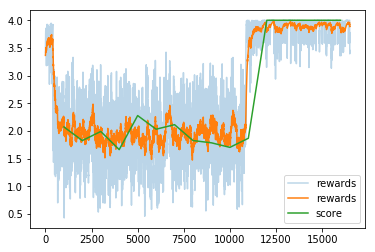

In [87]:
generateResults(0,4)

Episode: 1000, Recent reward average: 1.93 steps average: 0.05, eps:0.100 score:1.909
Episode: 2000, Recent reward average: 2.06 steps average: 0.46, eps:0.100 score:1.663
Episode: 3000, Recent reward average: 2.00 steps average: 0.16, eps:0.100 score:2.278
Episode: 4000, Recent reward average: 1.97 steps average: 0.38, eps:0.100 score:1.950
Episode: 5000, Recent reward average: 2.02 steps average: 0.35, eps:0.100 score:1.909
Episode: 6000, Recent reward average: 2.03 steps average: 0.21, eps:0.100 score:2.278
Episode: 7000, Recent reward average: 2.01 steps average: 0.16, eps:0.100 score:2.073
Episode: 8000, Recent reward average: 2.45 steps average: 0.09, eps:0.100 score:4.000
Episode: 9000, Recent reward average: 3.86 steps average: 0.05, eps:0.100 score:4.000
.Episode: 10000, Recent reward average: 3.87 steps average: 0.07, eps:0.100 score:4.000
Episode: 11000, Recent reward average: 3.90 steps average: 0.07, eps:0.100 score:4.000
Episode: 12000, Recent reward average: 3.87 steps a

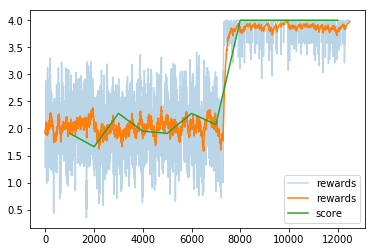

Episode: 1000, Recent reward average: -7.66 steps average: 154.74, eps:0.100 score:1.777
Episode: 2000, Recent reward average: 1.80 steps average: 6.26, eps:0.100 score:1.900
Episode: 3000, Recent reward average: 1.86 steps average: 5.75, eps:0.100 score:1.654
Episode: 4000, Recent reward average: 1.98 steps average: 5.72, eps:0.100 score:1.777
Episode: 5000, Recent reward average: 1.92 steps average: 5.58, eps:0.100 score:1.900
Episode: 6000, Recent reward average: 1.87 steps average: 5.65, eps:0.100 score:2.310
Episode: 7000, Recent reward average: 1.87 steps average: 5.86, eps:0.100 score:1.736
Episode: 8000, Recent reward average: 1.98 steps average: 9.11, eps:0.100 score:3.950
Episode: 9000, Recent reward average: 3.64 steps average: 7.11, eps:0.100 score:3.950
.Episode: 10000, Recent reward average: 3.70 steps average: 6.76, eps:0.100 score:3.950
Episode: 11000, Recent reward average: 3.79 steps average: 5.96, eps:0.100 score:3.950
Episode: 12000, Recent reward average: 3.74 step

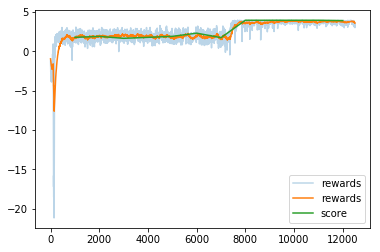

In [80]:
generateResults(0,6,step_reward=-0.01, originalAgent=False)

In [18]:
def print_lstm(agent):
    # memory state
    print(np.array(agent.h_state.detach()), np.array(agent.c_state.detach()))
    
print_lstm(agent)

[[[-0.27712888  0.25736347  0.19717823]]] [[[-0.4021521   0.6292797   0.33449498]]]


In [ ]:
# test agent
print(agent.epsilon)
env = TMaze(6)
eval_agent(agent=agent, env=env, trials=1, verbose=True, use_egreedy=True)

In [20]:
print("Episode: {}, Recent reward average: {:.2f} steps average: {:.2f}, eps:{:.3f}".format(
                    i, 
                    np.mean(totalRewards[-1000:]),
                    np.mean(totalSteps[-1000:]),
                    EPSILON))


Episode: 99, Recent reward average: 2.14 steps average: 0.05, eps:0.100


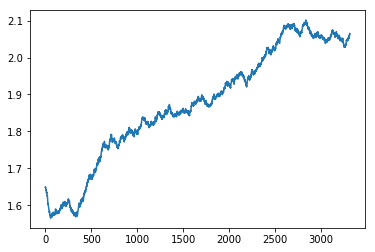

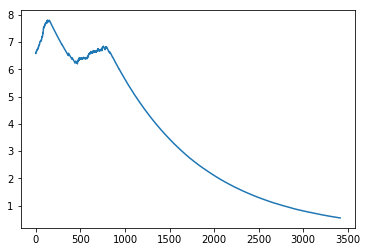

In [21]:
def smooth(X, gamma = 0.9):
    """ Returns exponential moving average. """
    y = np.mean(X[:500])
    out = []
    for x in X:
        y = gamma * y + (1-gamma) * x
        out.append(y)
    return out

plt.plot(range(len(totalRewards[100:])), smooth(totalRewards[100:],0.999), label = "rewards")
plt.show()
plt.plot(range(len(totalSteps)), smooth(totalSteps, 0.999), label = 'steps')
plt.show()

Yo/
